# Category Prediction Layer

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
import pandas as pd
import os

npx.set_np()

def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3, padding=1)

# Bounding Box Prediction Layer

In [2]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

In [3]:
def forward(x, block):
    block.initialize()
    return block(x)

Y1 = forward(np.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(np.zeros((2, 16, 10, 10)), cls_predictor(3, 10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

In [4]:
def flatten_pred(pred):
    return npx.batch_flatten(pred.transpose(0, 2, 3, 1))

def concat_preds(preds):
    return np.concatenate([flatten_pred(p) for p in preds], axis=1)

In [5]:
concat_preds([Y1, Y2]).shape

(2, 25300)

# Height and Width Downsample Block

In [6]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels), nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

In [7]:
forward(np.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

In [8]:
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk

forward(np.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

# The complete model
__5 modules:__
- 1: Base network
- 2 -> 4: Height and width downsample blocks
- 5: Global maximum pooling layer (reduces height & width to 1)

In [9]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

In [10]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    
    return (Y, anchors, cls_preds, bbox_preds)

In [11]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [12]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            # The assignment statement is self.blk_i = get_blk(i)
            setattr(self, f"blk_{i}", get_blk(i))
            setattr(self, f"cls_{i}", cls_predictor(num_anchors, num_classes))
            setattr(self, f"bbox_{i}", bbox_predictor(num_anchors))
            
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X,
                                                                     getattr(self, f"blk_{i}"), sizes[i], ratios[i],
                                                                     getattr(self, f"cls_{i}"), getattr(self, f"bbox_{i}"))
        anchors = np.concatenate(anchors, axis=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1,
                                      self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [13]:
net = TinySSD(num_classes=1)
net.initialize()
X = np.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print("output anchors:", anchors.shape)
print("output class preds:", cls_preds.shape)
print("output bbox preds:", bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


# Losses:
- Category loss: Cross entropy
- Anchor box offset loss: L1

In [14]:
cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
bbox_loss = gluon.loss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_abels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    
    return cls + bbox

In [15]:
def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(axis=-1).astype(cls_labels.dtype) == cls_labels).sum())

In [16]:
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((np.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

# Training

In [17]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [18]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=device)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.2, 'wd': 5e-4})

MXNetError: Traceback (most recent call last):
  File "../src/imperative/imperative.cc", line 295
MXNetError: Check failed: !AGInfo: :IsNone(*i): Cannot differentiate node because it is not in a computational graph. You need to set is_recording to true or use autograd.record() to save computational graphs for backward. If you want to differentiate the same graph twice, you need to pass retain_graph=True to backward.

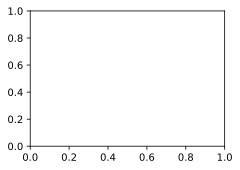

In [19]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel="epoch", xlim=[1, num_epochs],
                        legend=["class error", "bbox mae"])

for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    
    for features, target in train_iter:
        timer.start()
        X = features.as_in_ctx(device)
        Y = target.as_in_ctx(device)
        
        with autograd.record():
            # Generate multiscale anchor boxes and predict the category and offset of each
            bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
            
            # Calculate the loss function using the predicted and labeled category and offset values
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
            
        l.backward()
        trainer.step(batch_size)
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.size,
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.size)
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
    
print(f"class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}")
print(f"{len(train_ter._dataset) / timer.stop():.1f} examples/sec on "
      f"{str(device)}")